In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics_R
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



Num_Points = 4


In [2]:
# Load Forrester model

Reg_Data = BB_Model(dataset = 'Synthetic_Reg', Feature_Counts=[10,8])

#Reg_Data.df().head()

In [3]:
Reg_Data.MPL()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.46650695957154864


MLPRegressor(random_state=RandomState(MT19937) at 0x16A0A7E9840)

In [4]:
Reg_Data.Random_Forest()

0.46810563280544837


RandomForestRegressor(random_state=RandomState(MT19937) at 0x16A0A7E9840)

In [5]:
Reg_Data.GP()

-0.002232396530078562


GaussianProcessRegressor()

In [6]:
print(Reg_Data.get_features())

['Passive_0', 'Passive_1', 'Active_2', 'Active_3', 'Active_4', 'Active_5', 'Active_6', 'Active_7']


In [7]:
#Default settings
from unravel.tabular import UnRAVELTabularExplainer

X_train, X_test, y_train, y_test = Reg_Data.get_TT_data()

#Initializing the explainer object
Unravel_Exp = UnRAVELTabularExplainer(bbox_model           = Reg_Data.get_GP(),
                                      train_data           = X_train,
                                      categorical_features = Reg_Data.get_catagorical(),
                                      mode                 = Reg_Data.get_mode())

sur_GP = Surrogate_GP()



warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [8]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [ 13.95294597  18.48547009  19.19552922  12.46907878   7.49400943
  12.16544925 -11.38472474  13.44439752]
Std 0:  [4.6445628  3.96133266 4.18116873 3.30049199 2.80742767 1.59366948
 3.05075843 3.95996819]


In [9]:
# Generate explantion data for Random Forest

Reg_Stats = Feature_Statistics_R(feature_names = Reg_Data.get_features(), mode = Reg_Data.get_mode())

if Num_Points == 0: Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    scores = Unravel_Exp.explain(X_init            = data_row.reshape(1, -1),
                                 feature_names     = Reg_Data.get_features(),
                                 alpha             = "FUR_W",
                                 max_iter          = 20,
                                 normalize         = False,
                                 interval          = 1,
                                 importance_method = "KL")
       
       
    f_predict = Reg_Data.get_Random_Forest().predict(data_row.reshape(1, -1))

#    e_predict = Unravel_Exp.exp_predict(data_row.reshape(1, -1))
#    e_predict = np.array(e_predict).ravel()
    
    acq_data = Unravel_Exp.get_acq_data()
    
    X, y = Unravel_Exp.get_surrogate_data()

    e_predict = sur_GP.predict(X, y)

#    print(f_predict, e_predict, acq_data.get_fe_x0())
    
#    scores = Unravel_Exp.permutation_importance()
    
    Reg_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         model         = Unravel_Exp.get_gpmodel())


INSTANCE:  0
Acq_Data_nD
[5.02086259e-05 6.49217104e-06]
INSTANCE:  1
Acq_Data_nD
[-1.30193885e-02  9.94815181e-06]
INSTANCE:  2
Acq_Data_nD
[3.86552987e-04 9.62390662e-06]
INSTANCE:  3
Acq_Data_nD
[-9.68775177e-08  9.99999486e-06]


In [10]:
import matplotlib.pyplot as plt


In [11]:
print(f_predict)
print(e_predict)


[-61.97240981]
[-9.68775177e-08  9.99999486e-06]


In [12]:
Reg_Stats.Feature_Counts(max_features=20, scaled=True, threshold=0.05)


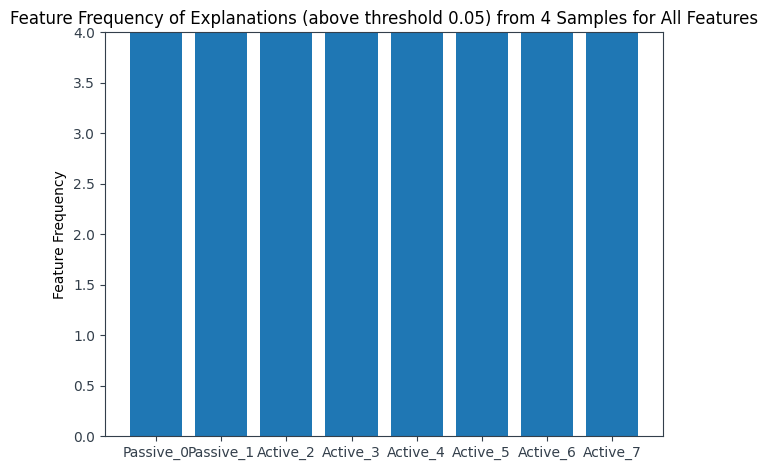

In [13]:
Reg_Stats.Frequency_Plot()


In [14]:
Reg_Stats.Fidelity()

Average, Var, and Max Differences:
y - BB(x):           66.13848347392974  :  3275.657544240211  :  140.3738016623137
y - exp(x):          76.98368389101763  :  6881.056512186348  :  218.67761982447453
BB(x) - exp(x):      49.12390538815217  :  580.651284973739  :  78.30381816216084
Average exp(x) var:  9.016056085530805e-06


In [15]:
Reg_Stats.Jaccard_Values()

Mean Jaccard Similarity:  0.5079365079365078
Mean Jaccard Distance:    0.49206349206349204


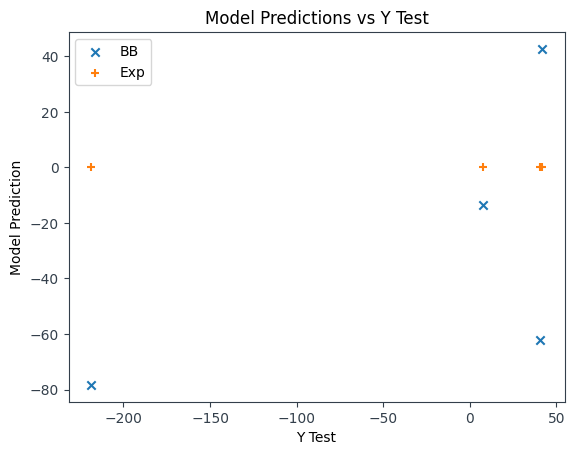

In [16]:
Reg_Stats.Reg_Fidelity_Graph()

top_features True
top_features (4, 8)


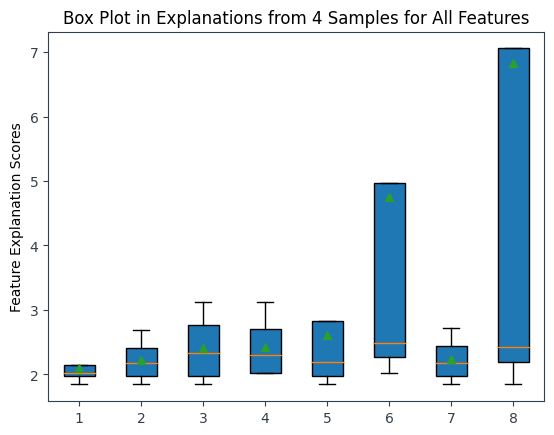

1 -      Passive_0
2 -      Passive_1
3 -      Active_2
4 -      Active_3
5 -      Active_4
6 -      Active_5
7 -      Active_6
8 -      Active_7


In [17]:
Reg_Stats.Box_Plot()


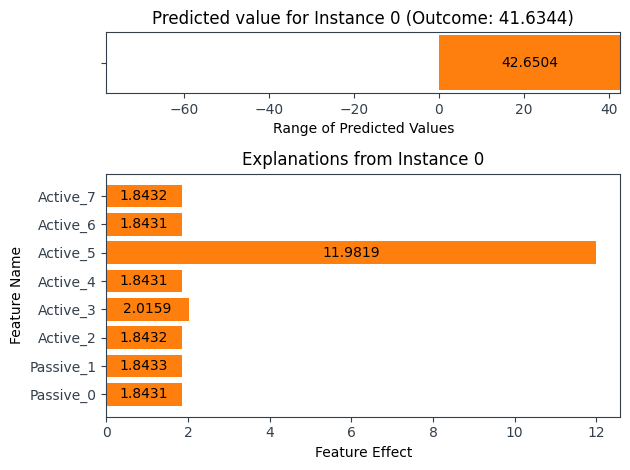

In [18]:
Reg_Stats.View_Explanation(instance = 0)

In [19]:
acq_data.Add_BB_model(Reg_Data.get_Random_Forest())
acq_data.Create_BB_plot()

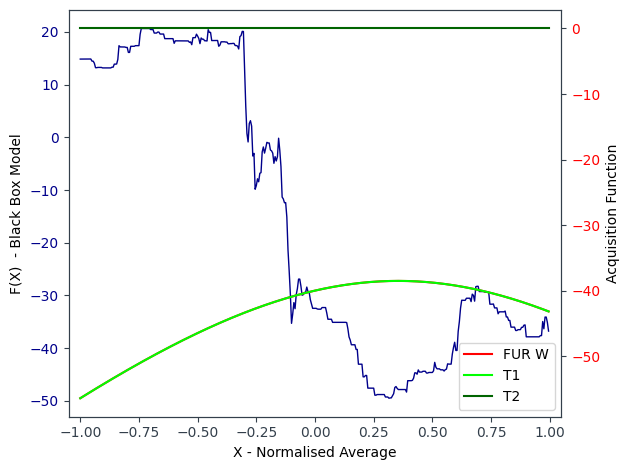

In [20]:
acq_data.plot_point(0)

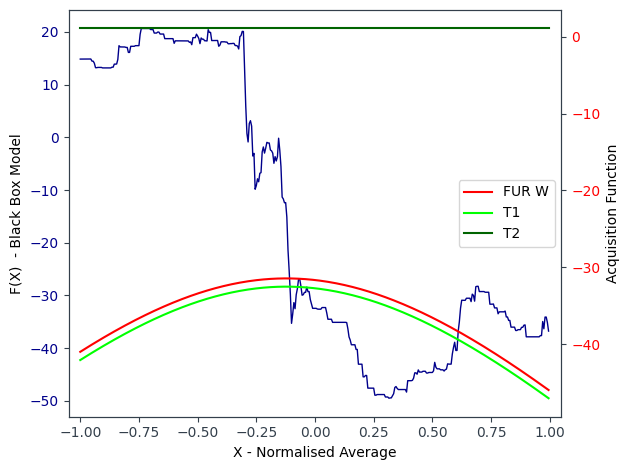

In [21]:
acq_data.plot_point(5)

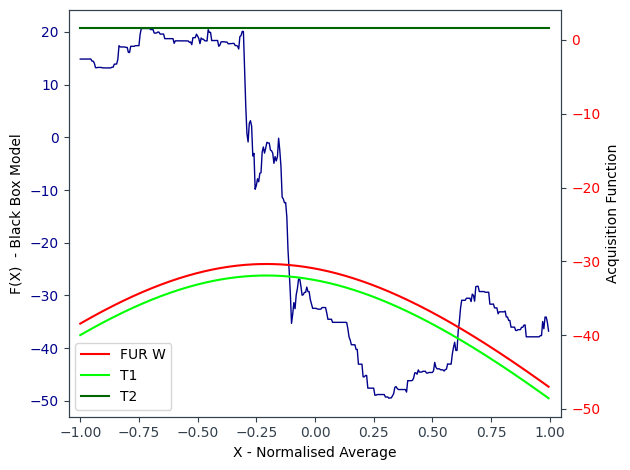

In [22]:
acq_data.plot_point(10)

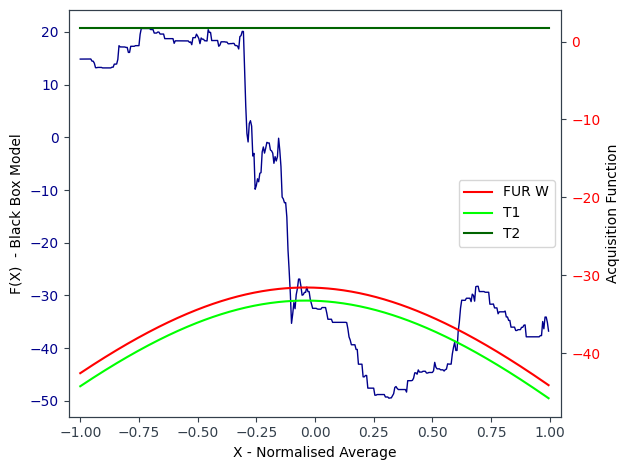

In [23]:
acq_data.plot_point(15)

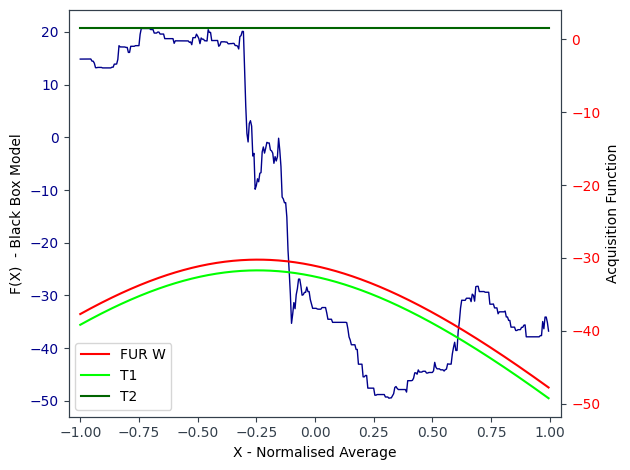

In [24]:
acq_data.plot_point(19)

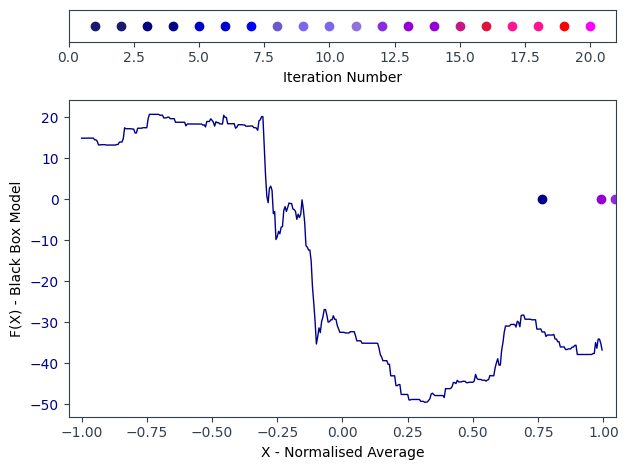

In [25]:
acq_data.plot_all()